# CS 224D Assignment #2
# Part [1]: Deep Networks: NER Window Model

For this first part of the assignment, you'll build your first "deep" networks. On problem set 1, you computed the backpropagation gradient $\frac{\partial J}{\partial w}$ for a two-layer network; in this problem set you'll implement a slightly more complex network to perform  named entity recognition (NER).

Before beginning the programming section, you should complete parts (a) and (b) of the corresponding section of the handout.

In [1]:
import sys, os
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 100

%load_ext autoreload
%autoreload 2

## (c): Random Initialization Test
Use the cell below to test your code.

In [2]:
from misc import random_weight_matrix
random.seed(10)
print random_weight_matrix(3,5)

[[ 0.46994114 -0.83008197  0.23148553  0.43094097 -0.00258593]
 [-0.47666619 -0.52297046  0.45125243 -0.57311684 -0.71301636]
 [ 0.32105262  0.78530031 -0.85918681  0.02111762  0.54147539]]


## (d): Implementation

We've provided starter code to load in the dataset and convert it to a list of "windows", consisting of indices into the matrix of word vectors. 

We pad each sentence with begin and end tokens `<s>` and `</s>`, which have their own word vector representations; additionally, we convert all words to lowercase, canonicalize digits (e.g. `1.12` becomes `DG.DGDG`), and replace unknown words with a special token `UUUNKKK`.

You don't need to worry about the details of this, but you can inspect the `docs` variables or look at the raw data (in plaintext) in the `./data/` directory.

In [3]:
import data_utils.utils as du
import data_utils.ner as ner

In [4]:
# Load the starter word vectors
wv, word_to_num, num_to_word = ner.load_wv('data/ner/vocab.txt',
                                           'data/ner/wordVectors.txt')
#wv:(100232,50)
#word_to_num:dict,100232
tagnames = ["O", "LOC", "MISC", "ORG", "PER"]
num_to_tag = dict(enumerate(tagnames))
tag_to_num = du.invert_dict(num_to_tag)

# Set window size
windowsize = 3

# Load the training set
docs = du.load_dataset('data/ner/train')
X_train, y_train = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                      wsize=windowsize)

# Load the dev set (for tuning hyperparameters)
docs = du.load_dataset('data/ner/dev')
X_dev, y_dev = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                  wsize=windowsize)

# Load the test set (dummy labels only)
docs = du.load_dataset('data/ner/test.masked')
X_test, y_test = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                    wsize=windowsize)

In [5]:
print num_to_tag
print tag_to_num
print wv.shape
print len(word_to_num)
print type(word_to_num)
print docs[0][:]
print X_train[0]
print y_train[0]

{0: 'O', 1: 'LOC', 2: 'MISC', 3: 'ORG', 4: 'PER'}
{'LOC': 1, 'MISC': 2, 'PER': 4, 'O': 0, 'ORG': 3}
(100232, 50)
100232
<type 'dict'>
[['SOCCER', 'O'], ['-', 'O'], ['JAPAN', 'O'], ['GET', 'O'], ['LUCKY', 'O'], ['WIN', 'O'], [',', 'O'], ['CHINA', 'O'], ['IN', 'O'], ['SURPRISE', 'O'], ['DEFEAT', 'O'], ['.', 'O']]
[   30  6659 12637]
3


To avoid re-inventing the wheel, we provide a base class that handles a lot of the drudgery of managing parameters and running gradient descent. It's based on the classifier API used by [`scikit-learn`](http://scikit-learn.org/stable/), so if you're familiar with that library it should be easy to use. 

We'll be using this class for the rest of this assignment, so it helps to get acquainted with a simple example that should be familiar from Assignment 1. To keep this notebook uncluttered, we've put the code in the `softmax_example.py`; take a look at it there, then run the cell below.

In [71]:
from softmax_example import SoftmaxRegression
sr = SoftmaxRegression(wv=zeros((10,100)), dims=(100,5))

##
# Automatic gradient checker!
# this checks anything you add to self.grads or self.sgrads
# using the method of Assignment 1

sr.grad_check(x=5, y=0)

# sr._acc_grads(idx=5,label=4)
# print sr.params.W.shape
# print sr.params.b.shape
# print sr.sparams.L.shape
# # print sr.sgrads.L[1].shape

# sr.compute_loss(idx=5,label=4)

grad_check: dJ/db error norm = 3.555e-10 [ok]
    b dims: [5] = 5 elem
grad_check: dJ/dW error norm = 1.852e-11 [ok]
    W dims: [5, 100] = 500 elem
grad_check: dJ/dL[5] error norm = 2.075e-11 [ok]
    L[5] dims: [100] = 100 elem


In order to implement a model, you need to subclass `NNBase`, then implement the following methods:

- `__init__()` (initialize parameters and hyperparameters)
- `_acc_grads()` (compute and accumulate gradients)
- `compute_loss()` (compute loss for a training example)
- `predict()`, `predict_proba()`, or other prediction method (for evaluation)

`NNBase` provides you with a few others that will be helpful:

- `grad_check()` (run a gradient check - calls `_acc_grads` and `compute_loss`)
- `train_sgd()` (run SGD training; more on this later)

Your task is to implement the window model in `nerwindow.py`; a scaffold has been provided for you with instructions on what to fill in.

When ready, you can test below:

In [72]:
wv.shape

(100232, 50)

In [5]:
from nerwindow import WindowMLP
clf = WindowMLP(wv, windowsize=windowsize, dims=[None, 100, 5],
                reg=0.001, alpha=0.01)
# clf._acc_grads(X_train[0],y_train[0])
clf.grad_check(X_train[0], y_train[0]) # gradient check on single point

grad_check: dJ/db2 error norm = 3.222e-10 [ok]
    b2 dims: [5] = 5 elem
grad_check: dJ/dU error norm = 2.843e-10 [ok]
    U dims: [5, 100] = 500 elem
grad_check: dJ/db1 error norm = 2.851e-09 [ok]
    b1 dims: [100] = 100 elem
grad_check: dJ/dW error norm = 1.337e-08 [ok]
    W dims: [100, 150] = 15000 elem
grad_check: dJ/dL[(30, slice(None, None, None))] error norm = 3.654e-11 [ok]
    L[(30, slice(None, None, None))] dims: [50] = 50 elem
grad_check: dJ/dL[(6659, slice(None, None, None))] error norm = 4.283e-11 [ok]
    L[(6659, slice(None, None, None))] dims: [50] = 50 elem
grad_check: dJ/dL[(12637, slice(None, None, None))] error norm = 4.633e-11 [ok]
    L[(12637, slice(None, None, None))] dims: [50] = 50 elem


Now we'll train your model on some data! You can implement your own SGD method, but we recommend that you just call `clf.train_sgd`. This takes the following arguments:

- `X`, `y` : training data
- `idxiter`: iterable (list or generator) that gives index (row of X) of training examples in the order they should be visited by SGD
- `printevery`: int, prints progress after this many examples
- `costevery`: int, computes mean loss after this many examples. This is a costly operation, so don't make this too frequent!

The implementation we give you supports minibatch learning; if `idxiter` is a list-of-lists (or yields lists), then gradients will be computed for all indices in a minibatch before modifying the parameters (this is why we have you write `_acc_grad` instead of applying them directly!).

Before training, you should generate a training schedule to pass as `idxiter`. If you know how to use Python generators, we recommend those; otherwise, just make a static list. Make the following in the cell below:

- An "epoch" schedule that just iterates through the training set, in order, `nepoch` times.
- A random schedule of `N` examples sampled with replacement from the training set.
- A random schedule of `N/k` minibatches of size `k`, sampled with replacement from the training set.

In [121]:
print X_train.shape
print type(xrange(5))
print 4*range(4)

(203621, 3)
<type 'xrange'>
[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]


In [7]:
nepoch = 5
N = nepoch * len(y_train)#5*203621
k = 5 # minibatch size

random.seed(10) # do not change this!
#### YOUR CODE HERE ####
indices = range(len(y_train))

#plan1:An "epoch" schedule that just iterates through the training set, in order, nepoch times
idxiter_epoch = nepoch * indices#solid sequence 12341234

#plan2:A random schedule of N examples sampled with replacement from the training set.
idxiter_N = random.choice(indices, N)

#plan3:A random schedule of N/k minibatches of size k, sampled with replacement from the training set.
def idxiter_batches():
    num_batches = N / k
    for i in xrange(num_batches):
        yield random.choice(indices, k)#random.choice(range(2w),5)

#### END YOUR CODE ###

Now call `train_sgd` to train on `X_train`, `y_train`. To verify that things work, train on 100,000 examples or so to start (with any of the above schedules). This shouldn't take more than a couple minutes, and you should get a mean cross-entropy loss around 0.4.

Now, if this works well, it's time for production! You have three tasks here:

1. Train a good model
2. Plot a learning curve (cost vs. # of iterations)
3. Use your best model to predict the test set

You should train on the `train` data and evaluate performance on the `dev` set. The `test` data we provided has only dummy labels (everything is `O`); we'll compare your predictions to the true labels at grading time. 

Scroll down to section (f) for the evaluation code.

We don't expect you to spend too much time doing an exhaustive search here; the default parameters should work well, although you can certainly do better. Try to achieve an F1 score of at least 76% on the dev set, as reported by `eval_performance`.

Feel free to create new cells and write new code here, including new functions (helpers and otherwise) in `nerwindow.py`. When you have a good model, follow the instructions below to make predictions on the test set.

A strong model may require 10-20 passes (or equivalent number of random samples) through the training set and could take 20 minutes or more to train - but it's also possible to be much, much faster!

Things you may want to tune:
- `alpha` (including using an "annealing" schedule to decrease the learning rate over time)
- training schedule and minibatch size
- regularization strength
- hidden layer dimension
- width of context window

In [120]:
#### YOUR CODE HERE ####
# Sandbox: build a good model by tuning hyperparameters
clf.train_sgd(X_train[:100000], y_train[:100000], idxiter=xrange(100000), printevery=5000, costevery=5000,)

#### END YOUR CODE ####

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77621
  Seen 5000 in 9.29 s
  [5000]: mean loss 0.546731
  Seen 10000 in 18.59 s
  [10000]: mean loss 0.492621
  Seen 15000 in 27.68 s
  [15000]: mean loss 0.536316
  Seen 20000 in 36.83 s
  [20000]: mean loss 0.432389
  Seen 25000 in 46.02 s
  [25000]: mean loss 0.457077
  Seen 30000 in 55.31 s
  [30000]: mean loss 0.456467
  Seen 35000 in 64.60 s
  [35000]: mean loss 0.759436
  Seen 40000 in 73.77 s
  [40000]: mean loss 0.480589
  Seen 45000 in 83.03 s
  [45000]: mean loss 0.430757
  Seen 50000 in 92.37 s
  [50000]: mean loss 0.48871
  Seen 55000 in 101.61 s
  [55000]: mean loss 0.502654
  Seen 60000 in 110.70 s
  [60000]: mean loss 0.403107
  Seen 65000 in 119.96 s
  [65000]: mean loss 0.566721
  Seen 70000 in 129.16 s
  [70000]: mean loss 0.535657
  Seen 75000 in 138.54 s
  [75000]: mean loss 0.384172
  Seen 80000 in 147.79 s
  [80000]: mean loss 0.374414
  Seen 85000 in 156.91 s
  [85000]: mean loss 0.364633
  Seen 90000 in 166.00

[(0, 1.7762140406391631),
 (5000, 0.54673139756366629),
 (10000, 0.49262096676418876),
 (15000, 0.53631624928688082),
 (20000, 0.43238885492936263),
 (25000, 0.45707727460393827),
 (30000, 0.45646657689837805),
 (35000, 0.75943559740036204),
 (40000, 0.480588573064686),
 (45000, 0.43075668102230702),
 (50000, 0.48871001440194095),
 (55000, 0.50265351925045387),
 (60000, 0.40310735445654289),
 (65000, 0.56672086611347983),
 (70000, 0.53565694416483833),
 (75000, 0.38417185972359313),
 (80000, 0.37441410368122474),
 (85000, 0.36463289723808223),
 (90000, 0.38919416767931847),
 (95000, 0.37875973328719309),
 (100000, 0.34570729477983142)]

In [ ]:
#### YOUR CODE HERE ####
# Sandbox: build a good model by tuning hyperparameters
from nerwindow import full_report, eval_performance

schedules = [idxiter_epoch, idxiter_N, idxiter_batches()]#last one is best, but slow. choose second
for train_idxiter in schedules:
    clf = WindowMLP(wv, windowsize=windowsize, dims=[None, 100, 5], reg=0.001, alpha=0.01)
    clf.train_sgd(X_train, y_train, idxiter=train_idxiter, printevery=250000, costevery=250000,)
    yp = clf.predict(X_dev)
    full_report(y_dev, yp, tagnames) # full report, helpful diagnostics
    eval_performance(y_dev, yp, tagnames) # performance: optimize this F1

#### END YOUR CODE ####

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 250000 in 107.03 s
  [250000]: mean loss 0.32933
  Seen 500000 in 214.00 s
  [500000]: mean loss 0.28802
  Seen 750000 in 319.30 s
  [750000]: mean loss 0.302339
  Seen 1000000 in 424.87 s
  [1000000]: mean loss 0.226065
  [1018105]: mean loss 0.19244
SGD complete: 1018105 examples in 461.36 seconds.
             precision    recall  f1-score   support

          O       0.96      0.97      0.96     42759
        LOC       0.80      0.81      0.80      2094
       MISC       0.85      0.62      0.72      1268
        ORG       0.76      0.37      0.49      2092
        PER       0.65      0.86      0.74      3149

avg / total       0.92      0.92      0.92     51362

=== Performance (omitting 'O' class) ===
Mean precision:  74.30%
Mean recall:     69.05%
Mean F1:         69.21%
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 250000 in 104.77 s
  [250000]: mean loss 0.224325
  Seen 500000 in 209.91 s
  [5000

In [8]:
#### YOUR CODE HERE ####
# Sandbox: build a good model by tuning hyperparameters
from nerwindow import full_report, eval_performance

regs = [0.0005, 0.0001, 0.00005]#0.0001 is best
for reg in regs:
    print "===== Regularization %f:" % reg
    clf = WindowMLP(wv, windowsize=windowsize, dims=[None, 100, 5], reg=reg, alpha=0.01)
    clf.train_sgd(X_train, y_train, idxiter=idxiter_batches(), printevery=10000, costevery=10000,)
    yp = clf.predict(X_dev)
    full_report(y_dev, yp, tagnames) # full report, helpful diagnostics
    eval_performance(y_dev, yp, tagnames) # performance: optimize this F1

#### END YOUR CODE ####

===== Regularization 0.000500:
Begin SGD...
  Seen 0 in 0.06 s
  [0]: mean loss 1.77988
  Seen 10000 in 470.47 s
  [10000]: mean loss 0.313174
  Seen 20000 in 943.86 s
  [20000]: mean loss 0.28002
  Seen 30000 in 1411.68 s
  [30000]: mean loss 0.246353
  Seen 40000 in 1888.60 s
  [40000]: mean loss 0.224633
  Seen 50000 in 2363.12 s
  [50000]: mean loss 0.208303
  Seen 60000 in 2828.87 s
  [60000]: mean loss 0.190137
  Seen 70000 in 3295.42 s
  [70000]: mean loss 0.179158
  Seen 80000 in 3761.64 s
  [80000]: mean loss 0.165485
  Seen 90000 in 4228.00 s
  [90000]: mean loss 0.159632
  Seen 100000 in 4694.29 s
  [100000]: mean loss 0.150413
  Seen 110000 in 5160.92 s
  [110000]: mean loss 0.142428
  Seen 120000 in 5627.95 s
  [120000]: mean loss 0.138818
  Seen 130000 in 6094.22 s
  [130000]: mean loss 0.134578
  Seen 140000 in 6575.19 s
  [140000]: mean loss 0.129752
  Seen 150000 in 7060.46 s
  [150000]: mean loss 0.126521
  Seen 160000 in 7613.59 s
  [160000]: mean loss 0.119185
  See

In [12]:
wv.shape

(100232, 50)

In [16]:
from nerwindow import full_report, eval_performance
window_sizes = [5, 7, 9]#7 is best
for window_size in window_sizes:
    
    # Load the training set
    X_train, y_train = du.docs_to_windows(du.load_dataset('data/ner/train'), word_to_num, tag_to_num, wsize=window_size)
    # Load the dev set (for tuning hyperparameters)
    X_dev, y_dev = du.docs_to_windows(du.load_dataset('data/ner/dev'), word_to_num, tag_to_num, wsize=window_size)
    
    print "===== window_size %f:" % window_size
    clf = WindowMLP(wv, windowsize=window_size, dims=[None, 100, 5], reg=0.0001, alpha=0.01)
    clf.train_sgd(X_train, y_train, idxiter=idxiter_N, printevery=250000, costevery=250000,)
    yp = clf.predict(X_dev)
    full_report(y_dev, yp, tagnames) # full report, helpful diagnostics
    eval_performance(y_dev, yp, tagnames) # performance: optimize this F1

===== window_size 5.000000:
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.9314
  Seen 250000 in 86.35 s
  [250000]: mean loss 0.200752
  Seen 500000 in 170.98 s
  [500000]: mean loss 0.125639
  Seen 750000 in 259.10 s
  [750000]: mean loss 0.0912266
  Seen 1000000 in 347.21 s
  [1000000]: mean loss 0.0687361
  [1018105]: mean loss 0.0741026
SGD complete: 1018105 examples in 374.85 seconds.
             precision    recall  f1-score   support

          O       0.96      0.99      0.98     42759
        LOC       0.88      0.86      0.87      2094
       MISC       0.88      0.68      0.77      1268
        ORG       0.83      0.61      0.70      2092
        PER       0.92      0.81      0.86      3149

avg / total       0.95      0.95      0.95     51362

=== Performance (omitting 'O' class) ===
Mean precision:  87.99%
Mean recall:     75.38%
Mean F1:         80.97%
===== window_size 7.000000:
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.91824
  Seen 250000 in 104.90 s
  [2

In [19]:
#using inverse decay to change learning rate
gamma=0.0001
power=0.75
base_lr=0.01
def alphaiter_inv(gamma=0.0001,power=0.75,base_lr=0.01):
    i=0
    while i<N:
        i+=1
        lr=base_lr*(1.0+gamma*i)**(-power)
        yield lr
        


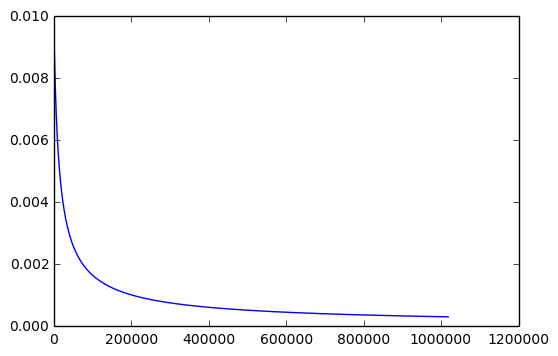

In [25]:
import matplotlib.pyplot as plt
lr_values_inv=np.array(list(alphaiter_inv()),dtype='float_')
lr_values_inv.shape
plt.plot(range(len(lr_values_inv)),lr_values_inv)

In [26]:
reg=0.0001
window_size=7

# Load the training set
X_train, y_train = du.docs_to_windows(du.load_dataset('data/ner/train'), word_to_num, tag_to_num, wsize=window_size)
# Load the dev set (for tuning hyperparameters)
X_dev, y_dev = du.docs_to_windows(du.load_dataset('data/ner/dev'), word_to_num, tag_to_num, wsize=window_size)

clf = WindowMLP(wv, windowsize=window_size, dims=[None, 100, 5], reg=0.0001)
clf.train_sgd(X_train, y_train, idxiter=idxiter_N, alphaiter=alphaiter_inv(), printevery=250000, costevery=250000,)
yp = clf.predict(X_dev)
full_report(y_dev, yp, tagnames) # full report, helpful diagnostics
eval_performance(y_dev, yp, tagnames) # performance: optimize this F1

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.91824
  Seen 250000 in 103.00 s
  [250000]: mean loss 0.249086
  Seen 500000 in 205.02 s
  [500000]: mean loss 0.223234
  Seen 750000 in 307.73 s
  [750000]: mean loss 0.209223
  Seen 1000000 in 411.60 s
  [1000000]: mean loss 0.200619
  [1018105]: mean loss 0.199927
SGD complete: 1018105 examples in 443.19 seconds.
             precision    recall  f1-score   support

          O       0.95      0.98      0.97     42759
        LOC       0.82      0.75      0.78      2094
       MISC       0.74      0.47      0.57      1268
        ORG       0.70      0.44      0.54      2092
        PER       0.82      0.80      0.81      3149

avg / total       0.92      0.93      0.92     51362

=== Performance (omitting 'O' class) ===
Mean precision:  77.66%
Mean recall:     65.15%
Mean F1:         70.25%


In [9]:
from nerwindow import full_report, eval_performance
reg=0.0001
window_size=7

# Load the training set
X_train, y_train = du.docs_to_windows(du.load_dataset('data/ner/train'), word_to_num, tag_to_num, wsize=window_size)
# Load the dev set (for tuning hyperparameters)
X_dev, y_dev = du.docs_to_windows(du.load_dataset('data/ner/dev'), word_to_num, tag_to_num, wsize=window_size)

clf = WindowMLP(wv, windowsize=window_size, dims=[None, 100, 5], reg=0.0001,alpha=0.01)
traincurvebest = clf.train_sgd(X_train, y_train, idxiter=idxiter_N, printevery=250000, costevery=250000,)
yp = clf.predict(X_dev)
full_report(y_dev, yp, tagnames) # full report, helpful diagnostics
eval_performance(y_dev, yp, tagnames) # performance: optimize this F1

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.91824
  Seen 250000 in 108.55 s
  [250000]: mean loss 0.189646
  Seen 500000 in 216.56 s
  [500000]: mean loss 0.126841
  Seen 750000 in 324.59 s
  [750000]: mean loss 0.0894728
  Seen 1000000 in 432.85 s
  [1000000]: mean loss 0.0658873
  [1018105]: mean loss 0.0654942
SGD complete: 1018105 examples in 465.30 seconds.
             precision    recall  f1-score   support

          O       0.97      0.99      0.98     42759
        LOC       0.89      0.85      0.87      2094
       MISC       0.85      0.69      0.76      1268
        ORG       0.78      0.65      0.71      2092
        PER       0.90      0.84      0.86      3149

avg / total       0.95      0.95      0.95     51362

=== Performance (omitting 'O' class) ===
Mean precision:  85.90%
Mean recall:     77.21%
Mean F1:         81.24%


## (e): Plot Learning Curves
The `train_sgd` function returns a list of points `(counter, cost)` giving the mean loss after that number of SGD iterations.

If the model is taking too long you can cut it off by going to *Kernel->Interrupt* in the IPython menu; `train_sgd` will return the training curve so-far, and you can restart without losing your training progress.

Make two plots:

- Learning curve using `reg = 0.001`, and comparing the effect of changing the learning rate: run with `alpha = 0.01` and `alpha = 0.1`. Use minibatches of size 5, and train for 10,000 minibatches with `costevery=200`. Be sure to scale up your counts (x-axis) to reflect the batch size. What happens if the model tries to learn too fast? Explain why this occurs, based on the relation of SGD to the true objective.

- Learning curve for your best model (print the hyperparameters in the title), as trained using your best schedule. Set `costevery` so that you get at least 100 points to plot.

In [47]:
traincurvebest

[(0, 1.9182407699345527),
 (250000, 0.18964619267066435),
 (500000, 0.12684128392871438),
 (750000, 0.089472780727067519),
 (1000000, 0.065887265320681329),
 (1018105, 0.065494209222125399)]

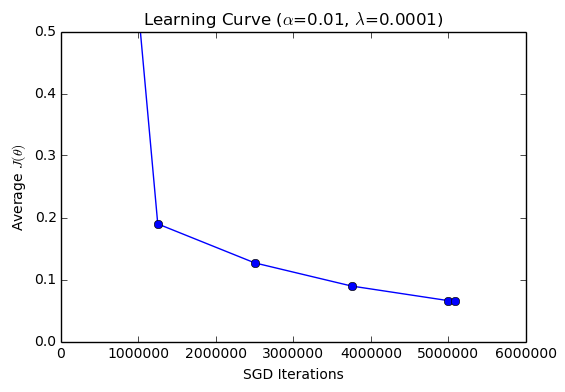

In [29]:
##
# Plot your best learning curve here
counts, costs = zip(*traincurvebest)
figure(figsize=(6,4))
plot(5*array(counts), costs, color='b', marker='o', linestyle='-')
title(r"Learning Curve ($\alpha$=%g, $\lambda$=%g)" % (clf.alpha, clf.lreg))
xlabel("SGD Iterations"); ylabel(r"Average $J(\theta)$"); 
ylim(ymin=0, ymax=max(1.1*max(costs),3*min(costs)));
ylim(0,0.5)

# Don't change this filename!
savefig("ner.learningcurve.best.png")

(203621, 3) (203621,)
(51362, 3) (51362,)
Begin SGD...
  Seen 0 in 0.01 s
  [0]: mean loss 1.77988
  [200]: mean loss 0.458443
  [400]: mean loss 0.433393
  [600]: mean loss 0.414653
  [800]: mean loss 0.415561
  [1000]: mean loss 0.394092
  [1200]: mean loss 0.387008
  [1400]: mean loss 0.387926
  [1600]: mean loss 0.380776
  [1800]: mean loss 0.384529
  [2000]: mean loss 0.376289
  [2200]: mean loss 0.367217
  [2400]: mean loss 0.378007
  [2600]: mean loss 0.364172
  [2800]: mean loss 0.360213
  [3000]: mean loss 0.356571
  [3200]: mean loss 0.359281
  [3400]: mean loss 0.355689
  [3600]: mean loss 0.353342
  [3800]: mean loss 0.349917
  [4000]: mean loss 0.349598
  [4200]: mean loss 0.347983
  [4400]: mean loss 0.359116
  [4600]: mean loss 0.346698
  [4800]: mean loss 0.363263
  [5000]: mean loss 0.347247
  [5200]: mean loss 0.343579
  [5400]: mean loss 0.340457
  [5600]: mean loss 0.339013
  [5800]: mean loss 0.333272
  [6000]: mean loss 0.339263
  [6200]: mean loss 0.331303
  [640

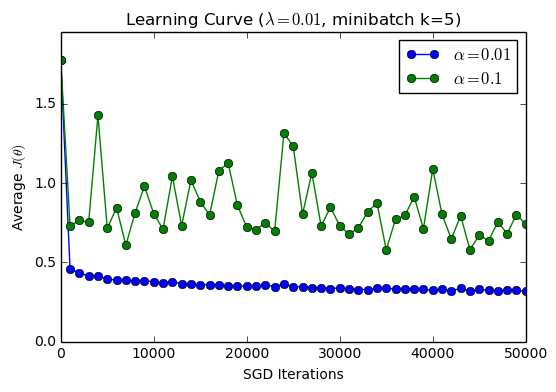

In [30]:
##
# Plot comparison of learning rates here
# feel free to change the code below

window_size = 3
# Load the training set
docs = du.load_dataset('data/ner/train')
X_train, y_train = du.docs_to_windows(docs, word_to_num, tag_to_num, wsize=window_size)

# Load the dev set (for tuning hyperparameters)
docs = du.load_dataset('data/ner/dev')
X_dev, y_dev = du.docs_to_windows(docs, word_to_num, tag_to_num, wsize=window_size)

def idxiter_batches1():
    num_batches = 10000
    for i in xrange(num_batches):
        yield random.choice(indices, 5)

print X_train.shape, y_train.shape
print X_dev.shape, y_dev.shape

clf1 = WindowMLP(wv, windowsize=window_size, dims=[None, 100, 5], reg=0.001, alpha=0.01)
trainingcurve1 = clf1.train_sgd(X_train, y_train, idxiter=idxiter_batches1(), printevery=50000, costevery=200)
clf2 = WindowMLP(wv, windowsize=window_size, dims=[None, 100, 5], reg=0.001, alpha=0.1)
trainingcurve2 = clf2.train_sgd(X_train, y_train, idxiter=idxiter_batches1(), printevery=50000, costevery=200)


figure(figsize=(6,4))
counts, costs = zip(*trainingcurve1)
plot(5*array(counts), costs, color='b', marker='o', linestyle='-', label=r"$\alpha=0.01$")
counts, costs = zip(*trainingcurve2)
plot(5*array(counts), costs, color='g', marker='o', linestyle='-', label=r"$\alpha=0.1$")
title(r"Learning Curve ($\lambda=0.01$, minibatch k=5)")
xlabel("SGD Iterations"); ylabel(r"Average $J(\theta)$"); 
ylim(ymin=0, ymax=max(1.1*max(costs),3*min(costs)));
legend()

# Don't change this filename
savefig("ner.learningcurve.comparison.png")

## (f): Evaluating your model
Evaluate the model on the dev set using your `predict` function, and compute performance metrics below!

In [49]:
window_size=7
# Load the training set
X_train, y_train = du.docs_to_windows(du.load_dataset('data/ner/train'), word_to_num, tag_to_num, wsize=window_size)
# Load the dev set (for tuning hyperparameters)
X_dev, y_dev = du.docs_to_windows(du.load_dataset('data/ner/dev'), word_to_num, tag_to_num, wsize=window_size)
# Predict labels on the dev set
yp = clf.predict(X_dev)
# Save predictions to a file, one per line
ner.save_predictions(yp, "dev.predicted")

In [51]:
from nerwindow import full_report, eval_performance
full_report(y_dev, yp, tagnames) # full report, helpful diagnostics
eval_performance(y_dev, yp, tagnames) # performance: optimize this F1

             precision    recall  f1-score   support

          O       0.97      0.99      0.98     42759
        LOC       0.89      0.85      0.87      2094
       MISC       0.85      0.69      0.76      1268
        ORG       0.78      0.65      0.71      2092
        PER       0.90      0.84      0.86      3149

avg / total       0.95      0.95      0.95     51362

=== Performance (omitting 'O' class) ===
Mean precision:  85.90%
Mean recall:     77.21%
Mean F1:         81.24%


In [57]:
# Save your predictions on the test set for us to evaluate
# IMPORTANT: make sure X_test is exactly as loaded 
# from du.docs_to_windows, so that your predictions 
# line up with ours.
# Load the test set (dummy labels only)
window_size=7
docs = du.load_dataset('data/ner/test.masked')
X_test, y_test = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                    wsize=window_size)

yptest = clf.predict(X_test)
ner.save_predictions(yptest, "test.predicted")

## Part [1.1]: Probing neuron responses

You might have seen some results from computer vision where the individual neurons learn to detect edges, shapes, or even [cat faces](http://googleblog.blogspot.com/2012/06/using-large-scale-brain-simulations-for.html). We're going to do the same for language.

Recall that each "neuron" is essentially a logistic regression unit, with weights corresponding to rows of the corresponding matrix. So, if we have a hidden layer of dimension 100, then we can think of our matrix $W \in \mathbb{R}^{100 x 150}$ as representing 100 hidden neurons each with weights `W[i,:]` and bias `b1[i]`.

### (a): Hidden Layer, Center Word
For now, let's just look at the center word, and ignore the rest of the window. This corresponds to columns `W[:,50:100]`, although this could change if you altered the window size for your model. For each neuron, find the top 10 words that it responds to, as measured by the dot product between `W[i,50:100]` and `L[j]`. Use the provided code to print these words and their scores for 5 neurons of your choice. In your writeup, briefly describe what you notice here.

The `num_to_word` dictionary, loaded earlier, may be helpful.

In [11]:
# Recommended function to print scores
# scores = list of float
# words = list of str
def print_scores(scores, words):
    for i in range(len(scores)):
        print "[%d]: (%.03f) %s" % (i, scores[i], words[i])

In [72]:
# Recommended function to print scores
# scores = list of float
# words = list of str
def print_scores(scores, words):
    for i in range(len(scores)):
        print "[%d]: (%.03f) %s" % (i, scores[i], words[i])

#### YOUR CODE HERE ####

neurons = [1,3,4,6,8] # change this to your chosen neurons
for i in neurons:
    print "Neuron %d" % i
    
    # W[...] is 1 x 50, L is |V| x 50
    # get the argmax indices of this:
    dots = np.dot(clf.params.W[i, 150:200], clf.sparams.L.T)#(50,)(50,20w)=>(20w,)
    indices = dots.argsort()[-10:][::-1]
    words = [num_to_word[i] for i in indices]
    scores = [dots[i] for i in indices]
    
    print_scores(scores,words)
    
#### END YOUR CODE ####

Neuron 1
[0]: (2.474) netherlands
[1]: (2.395) referred
[2]: (2.052) italy
[3]: (2.017) sweden
[4]: (2.005) belgium
[5]: (1.977) germany
[6]: (1.958) situated
[7]: (1.921) consisting
[8]: (1.893) norway
[9]: (1.885) belonging
Neuron 3
[0]: (1.588) densely
[1]: (1.480) plain
[2]: (1.458) malaysia
[3]: (1.457) surrounded
[4]: (1.444) parallel
[5]: (1.433) faces
[6]: (1.399) solitary
[7]: (1.396) remote
[8]: (1.381) narrow
[9]: (1.364) vulnerable
Neuron 4
[0]: (1.745) there
[1]: (1.270) behalf
[2]: (1.167) homes
[3]: (1.128) lot
[4]: (1.108) shelter
[5]: (1.050) capacity
[6]: (1.040) partially
[7]: (1.034) height
[8]: (1.005) residence
[9]: (1.001) partly
Neuron 6
[0]: (2.664) jackson
[1]: (2.554) thompson
[2]: (2.544) carter
[3]: (2.538) russell
[4]: (2.529) adams
[5]: (2.506) james
[6]: (2.502) francis
[7]: (2.446) clinton
[8]: (2.427) wilson
[9]: (2.421) adam
Neuron 8
[0]: (3.828) number
[1]: (3.805) large
[2]: (3.790) areas
[3]: (3.636) regions
[4]: (3.609) size
[5]: (3.580) %
[6]: (3

### (b): Model Output, Center Word
Now, let's do the same for the output layer. Here we only have 5 neurons, one for each class. `O` isn't very interesting, but let's look at the other four.

Here things get a little more complicated: since we take a softmax, we can't just look at the neurons separately. An input could cause several of these neurons to all have a strong response, so we really need to compute the softmax output and find the strongest inputs for each class.

As before, let's consider only the center word (`W[:,50:100]`). For each class `ORG`, `PER`, `LOC`, and `MISC`, find the input words that give the highest probability $P(\text{class}\ |\ \text{word})$.

You'll need to do the full feed-forward computation here - for efficiency, try to express this as a matrix operation on $L$. This is the same feed-forward computation as used to predict probabilities, just with $W$ replaced by `W[:,50:100]`.

As with the hidden-layer neurons, print the top 10 words and their corresponding class probabilities for each class.

In [95]:
#### YOUR CODE HERE ####
from nn.math import softmax
topscores=[]
topwords=[]
for i in range(1,5):
    print "Output neuron %d: %s" % (i, num_to_tag[i])
    dots = np.dot(clf.params.W[:, 150:200], clf.sparams.L.T)+clf.params.b1.reshape((100,1))#(100,50)(50,20w)=>(100,20w)
    h = tanh(dots)#(100,)
    a2=clf.params.U.dot(h) + clf.params.b2.reshape((5,1))#(5,100)*(100,20w)+(5,)=>(5,20w)
    a2=a2.T
    
    N,C=a2.shape
    x_exp = np.exp(a2 - np.max(a2, axis=1).reshape(N, 1))
    p = x_exp / np.sum(x_exp, axis=1).reshape(N, 1)
    indices = p[:, i].argsort()[-10:][::-1]
    print 'indices:',indices
    words=[num_to_word[j] for j in indices]
    scores=[p[j,i] for j in indices]
    topscores.append(scores)
    topwords.append(words)

for i in range(1,5):
    print "Output neuron %d: %s" % (i, num_to_tag[i])
    print_scores(topscores[i-1], topwords[i-1])
    print ""

#### END YOUR CODE ####

Output neuron 1: LOC
indices: [2915 2313 1717 7837 2980  818 1381 1030 2647 2531]
Output neuron 2: MISC
indices: [  906  4996  3675  1968  4790   445  3590  3646   511 26075]
Output neuron 3: ORG
indices: [ 3273  3217 19488 22821  2854 10967  4580  4162  1994  7520]
Output neuron 4: PER
indices: [ 4475  3146  1189  7846 48469  3410 53641 36886 20685 28371]
Output neuron 1: LOC
[0]: (1.000) norway
[1]: (0.999) egypt
[2]: (0.999) pakistan
[3]: (0.999) zimbabwe
[4]: (0.998) switzerland
[5]: (0.998) referred
[6]: (0.998) russia
[7]: (0.998) italy
[8]: (0.998) iran
[9]: (0.998) sweden

Output neuron 2: MISC
[0]: (1.000) italian
[1]: (1.000) brazilian
[2]: (1.000) danish
[3]: (1.000) olympic
[4]: (1.000) belgian
[5]: (1.000) german
[6]: (1.000) egyptian
[7]: (1.000) turkish
[8]: (1.000) cup
[9]: (1.000) gmt

Output neuron 3: ORG
[0]: (1.000) commons
[1]: (1.000) charity
[2]: (1.000) corp
[3]: (1.000) reuters
[4]: (1.000) microsoft
[5]: (1.000) inc
[6]: (1.000) non-profit
[7]: (1.000) biology

### (c): Model Output, Preceding Word
Now for one final task: let's look at the preceding word. Repeat the above analysis for the output layer, but use the first part of $W$, i.e. `W[:,:50]`.

Describe what you see, and include these results in your writeup.

In [12]:
#### YOUR CODE HERE ####
h = tanh(clf.sparams.L.dot(clf.params.W[:, :50].T) + clf.params.b1)
a = h.dot(clf.params.U.T) + clf.params.b2
N, C = a.shape
x_exp = np.exp(a - np.max(a, axis=1).reshape(N, 1))
p = x_exp / np.sum(x_exp, axis=1).reshape(N, 1)
for i in range(1,5):
    print "Output neuron %d: %s" % (i, num_to_tag[i])
    indices = p[:, i].argsort()[-10:][::-1]
    print indices
    words = [num_to_word[j] for j in indices]
    scores = [p[j][i] for j in indices]
    print_scores(scores, words)
    print ""

#### END YOUR CODE ####

Output neuron 1: LOC
[ 1193  1485   199   227   836 13135  1082  7475 15433  2797]
[0]: (0.021) formerly
[1]: (0.011) surrounding
[2]: (0.009) named
[3]: (0.009) park
[4]: (0.008) native
[5]: (0.006) dune
[6]: (0.006) branch
[7]: (0.005) flora
[8]: (0.005) flock
[9]: (0.004) peninsula

Output neuron 2: MISC
[  346  2975   302  2189   731 15427   754  1399  3491  7258]
[0]: (0.499) according
[1]: (0.220) favor
[2]: (0.149) see
[3]: (0.147) v.
[4]: (0.129) [
[5]: (0.117) prohibit
[6]: (0.084) prior
[7]: (0.076) mentioned
[8]: (0.075) dispute
[9]: (0.072) resemble

Output neuron 3: ORG
[ 3548 10075  1707 19334  3172  1858   199 32481   433 31442]
[0]: (0.665) affiliated
[1]: (0.653) messenger
[2]: (0.567) inc.
[3]: (0.475) slough
[4]: (0.456) component
[5]: (0.437) v
[6]: (0.403) named
[7]: (0.363) tidewater
[8]: (0.351) association
[9]: (0.347) mussel

Output neuron 4: PER
[14522  2200  2757  5074  4562  2618 11262 26194 16992  9415]
[0]: (0.501) courtesy
[1]: (0.271) don
[2]: (0.226) ro